Nepal Earthquake OSM Data Exploration
=====================================

In [2]:
require '/opt/epic-osm/epic-osm.rb'
analysis_window = './nepal-earthquake.yml'
o  = EpicOSM.new(analysis_window: analysis_window)
aw = o.analysis_window

Successfully initialized Analysis Window: Nepal Earthquake



#<AnalysisWindow:0x007f3da7987ab0 @bounding_box=#<BoundingBox:0x007f3da798ce20 @bbox_array=["80.0134", "26.3033", "88.2202", "30.5149"], @bottom_left=[80.0134, 26.3033], @top_right=[88.2202, 30.5149], @active=false>, @time_frame=#<TimeFrame:0x007f3da798f4e0 @start_date=2015-04-25 00:00:00 +0000, @end_date=2015-05-31 00:00:00 +0000, @active=true>, @max_area=1000000000000, @min_area=1, @title="Nepal Earthquake", @changeset_tags=nil>

## Visualize some changesets information!

In [3]:
cSets_per_4hours = aw.changesets_x_hour(step: 4);
nil

{:unit=>:hour, :step=>4, :constraints=>{}, :collection=>"changesets", :type=>DomainObject::Changeset}
Query complete for: {:created_at=>{"$gte"=>2015-04-25 00:00:00 +0000, "$lt"=>2015-04-25 04:00:00 +0000}}
Query complete for: {:created_at=>{"$gte"=>2015-04-25 04:00:00 +0000, "$lt"=>2015-04-25 08:00:00 +0000}}
Query complete for: {:created_at=>{"$gte"=>2015-04-25 08:00:00 +0000, "$lt"=>2015-04-25 12:00:00 +0000}}
Query complete for: {:created_at=>{"$gte"=>2015-04-25 12:00:00 +0000, "$lt"=>2015-04-25 16:00:00 +0000}}
Query complete for: {:created_at=>{"$gte"=>2015-04-25 16:00:00 +0000, "$lt"=>2015-04-25 20:00:00 +0000}}
Query complete for: {:created_at=>{"$gte"=>2015-04-25 20:00:00 +0000, "$lt"=>2015-04-26 00:00:00 +0000}}
Query complete for: {:created_at=>{"$gte"=>2015-04-26 00:00:00 +0000, "$lt"=>2015-04-26 04:00:00 +0000}}
Query complete for: {:created_at=>{"$gte"=>2015-04-26 04:00:00 +0000, "$lt"=>2015-04-26 08:00:00 +0000}}
Query complete for: {:created_at=>{"$gte"=>2015-04-26 08:0

In [4]:
users_per_4hours = cSets_per_4hours.collect{|bucket| {time: bucket[:start_date], users: bucket[:objects].collect{|x| x.user}.uniq}}; nil

In [52]:
puts "Total unique users: #{ users_per_4hours.collect{|x| x[:users] }.flatten.uniq.length }"
u_count_per_4hour = users_per_4hours.collect{|x| x[:users].count}

Total unique users: 7068


[0, 4, 9, 65, 194, 137, 153, 179, 240, 314, 286, 211, 191, 247, 249, 414, 474, 308, 246, 215, 206, 291, 420, 310, 188, 201, 261, 402, 523, 384, 265, 246, 257, 307, 329, 311, 182, 178, 218, 268, 251, 221, 107, 96, 123, 146, 155, 132, 75, 68, 132, 134, 145, 143, 78, 111, 110, 159, 154, 119, 66, 81, 118, 152, 283, 199, 66, 88, 113, 178, 175, 129, 64, 68, 71, 112, 130, 96, 79, 66, 86, 91, 68, 90, 30, 48, 48, 62, 63, 57, 42, 35, 47, 47, 52, 70, 62, 40, 45, 51, 64, 82, 52, 64, 68, 100, 115, 122, 84, 67, 64, 89, 75, 99, 64, 46, 77, 87, 110, 107, 44, 36, 55, 74, 84, 94, 39, 44, 40, 47, 55, 50, 31, 34, 34, 31, 47, 54, 30, 51, 47, 45, 55, 56, 28, 36, 67, 66, 66, 85, 36, 43, 50, 45, 45, 57, 24, 28, 39, 45, 59, 50, 18, 24, 36, 54, 46, 48, 14, 13, 24, 29, 27, 25, 14, 23, 39, 47, 42, 38, 35, 30, 40, 50, 42, 39, 12, 31, 22, 52, 42, 64, 12, 29, 23, 24, 35, 33, 16, 13, 32, 23, 58, 34, 15, 13, 16, 18, 31, 33, 7, 17, 18, 22, 22, 13]

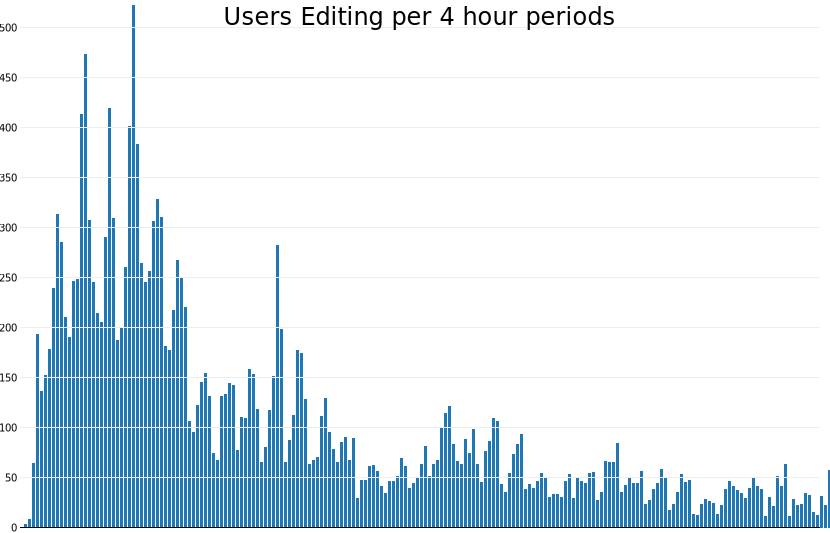

In [57]:
require 'rubyvis'
w = 800
h = u_count_per_4hour.max
#x = pv.Scale.linear(data, lambda {|d| d.x}).range(0, w)
y = pv.Scale.linear(0, h).range(0, h);

vis = Rubyvis::Panel.new do |p|
  p.width(w)
  .height(h)
  .left(20)
  .right(10)
  .top(5)
  .bottom(5)
  
  p.add(pv.Bar).data(u_count_per_4hour).
    width(3).
    height(lambda {|d| d * 1}).
    bottom(0).
  left(lambda {index * 4})
  
  p.add(pv.Rule)
    .data(y.ticks(10))
    .bottom(y)
    .strokeStyle(lambda {|d| d!=0 ? "#eee" : "#000"})
  .anchor("left").add(pv.Label)
  .text(y.tick_format);
  
  p.label(:anchor=>'top')
    .fontSize(24)
    .text("Users Editing per 4 hour periods")
end